In [1]:
import pandas as pd
from freesurfer_stats import CorticalParcellationStats
import glob
import re
import itertools
import numpy as np
import pyls
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import pickle
from sklearn import preprocessing
from scipy.stats import zscore
from nilearn import input_data
from nilearn import plotting
import pingouin as pg

/opt/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
sns.set_context("notebook", font_scale=1.7)
sns.set_style("whitegrid")

/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Carga datos funcionales

In [3]:
func_file = 'data/functional_strength_data_acq_short.csv'
func_data = pd.read_csv(func_file)
func_data.drop(columns=func_data.columns[0], axis=1, inplace=True)
#all_volumes.columns.to_list()

# Selección prisma 1
selected_values = func_data.loc[func_data['project'].isin(['prisma1','controles'])]

# Selección TAB y CTRL
selected_values = selected_values.loc[selected_values['group'].isin(['TAB','CTRL'])]
#selected_values

In [4]:
# Conteo datos iniciales
selected_values.groupby('group').describe()

7Networks_LH_Vis_1                                                       \
                   count       mean        std       min       25%        50%   
group                                                                           
CTRL                32.0  14.363881  10.932302  0.404651  4.890052  11.858522   
TAB                 39.0  19.070088  17.640826  0.532326  2.608257  15.122091   

                            7Networks_LH_Vis_2             ...  \
             75%        max              count       mean  ...   
group                                                      ...   
CTRL   23.547004  34.392861               32.0  11.488069  ...   
TAB    30.078793  87.754399               39.0  15.052220  ...   

      7Networks_Stra_Cont_6            7Networks_Stra_Default_7            \
                        75%        max                    count      mean   
group                                                                       
CTRL              12.555124  43.843471                     32.0  9.938004   
TAB               15.799214  49.886436                     39.0  7.714503   

                                                                 
             std  min       25%       50%        75%        max  
group                                                            
CTRL   11.485387  0.0  3.047059  7.359538  12.147215  61.409917  
TAB     5.863122  0.0  2.939112  6.438915  10.653762  20.862550  

[2 rows x 3080 columns]

In [5]:
selected_values.shape

(71, 388)

## Carga de datos clínicos

In [6]:
clinical_file = 'data/BFCN_t1_cov.xlsx'
clinical_data = pd.read_excel(clinical_file)
clinical_data.loc[clinical_data.subject.str.contains('CTRL'), 'project'] = 'controles'
# Selección de variables
clinical_data.drop(columns=['group','columna1','dim3','dim4','id_prisma'],inplace=True)
#clinical_data

## Merge both files

In [7]:
# Unión archivos volúmenes e información clínica
all_data = selected_values
clinical_image_df= pd.merge(all_data, clinical_data, how='left', on=['subject', 'project'])
clinical_image_df.groupby('group').describe()

7Networks_LH_Vis_1                                                       \
                   count       mean        std       min       25%        50%   
group                                                                           
CTRL                32.0  14.363881  10.932302  0.404651  4.890052  11.858522   
TAB                 39.0  19.070088  17.640826  0.532326  2.608257  15.122091   

                            7Networks_LH_Vis_2             ... psy_cpt_pun_t  \
             75%        max              count       mean  ...           75%   
group                                                      ...                 
CTRL   23.547004  34.392861               32.0  11.488069  ...           NaN   
TAB    30.078793  87.754399               39.0  15.052220  ...           NaN   

          psy_cpt_pun_t2                               
      max          count mean std min 25% 50% 75% max  
group                                                  
CTRL  NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB   NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [8]:
#Remove data for TAB and diagnosis 2
clinical_image_df.drop(clinical_image_df.index[clinical_image_df['diagnosis']=='Bipolar Affective Disorder 2'],inplace=True)
clinical_image_df.groupby('group').describe()

7Networks_LH_Vis_1                                                       \
                   count       mean        std       min       25%        50%   
group                                                                           
CTRL                32.0  14.363881  10.932302  0.404651  4.890052  11.858522   
TAB                 38.0  18.587199  17.614472  0.532326  2.515623  15.066374   

                            7Networks_LH_Vis_2             ... psy_cpt_pun_t  \
             75%        max              count       mean  ...           75%   
group                                                      ...                 
CTRL   23.547004  34.392861               32.0  11.488069  ...           NaN   
TAB    29.490301  87.754399               38.0  14.858988  ...           NaN   

          psy_cpt_pun_t2                               
      max          count mean std min 25% 50% 75% max  
group                                                  
CTRL  NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB   NaN            0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [9]:
clinical_image_df.head()

7Networks_LH_Vis_1  7Networks_LH_Vis_2  7Networks_LH_Vis_3  \
0           24.041703           19.569861           21.934051   
1           10.831601           10.356307           27.812565   
2           10.567363           14.681632           18.425490   
3            0.532326            0.632223           51.714608   
4            2.099198           22.675315            6.382682   

   7Networks_LH_Vis_4  7Networks_LH_Vis_5  7Networks_LH_Vis_6  \
0           11.179671           22.107610           13.252194   
1           19.632473           41.607259           33.768739   
2            5.780165           18.434202           12.960762   
3           34.729564           67.526132           69.576369   
4           25.195573           23.005291           10.631894   

   7Networks_LH_Vis_7  7Networks_LH_Vis_8  7Networks_LH_Vis_9  \
0           12.065503           14.914876           16.323810   
1            4.929675           11.648016           42.426268   
2            5.518837           31.555113           32.521117   
3            9.752884           12.575155           63.704453   
4           17.257076            5.574169           25.994466   

   7Networks_LH_Vis_10  ...  psy_cls_lns  psy_mccb_mazes  psy_mazes_pun_t  \
0            21.423033  ...          NaN             NaN              NaN   
1            42.138504  ...          NaN             NaN              NaN   
2            13.735861  ...          NaN             NaN              NaN   
3            59.510778  ...          NaN             NaN              NaN   
4            14.246707  ...          NaN             NaN              NaN   

   psy_cls_mazes  psy_mccb_fluency  psy_fluency_pun_t  psy_cls_fluency  \
0            NaN               NaN                NaN              NaN   
1            NaN               NaN                NaN              NaN   
2            NaN               NaN                NaN              NaN   
3            NaN               NaN                NaN              NaN   
4            NaN               NaN                NaN              NaN   

   psy_mccb_cpt  psy_cpt_pun_t  psy_cpt_pun_t2  
0           NaN            NaN             NaN  
1           NaN            NaN             NaN  
2           NaN            NaN             NaN  
3           NaN            NaN             NaN  
4           NaN            NaN             NaN  

[5 rows x 559 columns]

## Normalización de los datos

In [10]:
# Normalización z-score por fila (sujeto) para datos funcionales 0 a 385
clinical_image_z = clinical_image_df
clinical_image_z.iloc[:,:385] = clinical_image_z.iloc[:,:385].apply(zscore, axis=1) 
clinical_image_z.groupby('group').describe()

7Networks_LH_Vis_1                                                    \
                   count      mean       std       min       25%       50%   
group                                                                        
CTRL                32.0 -0.360513  0.919536 -1.617539 -1.167473 -0.467481   
TAB                 38.0 -0.137195  1.151323 -1.730071 -1.150239 -0.505332   

                          7Networks_LH_Vis_2            ... psy_cpt_pun_t      \
            75%       max              count      mean  ...           75% max   
group                                                   ...                     
CTRL   0.279905  1.314281               32.0 -0.562162  ...           NaN NaN   
TAB    0.627951  3.034255               38.0 -0.346785  ...           NaN NaN   

      psy_cpt_pun_t2                               
               count mean std min 25% 50% 75% max  
group                                              
CTRL             0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB              0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [11]:
#clinical_image_z.columns.to_list()

In [12]:
# Selección variables clínicas
list_regression = ['age','sex','education_level','fdmean_short',
                   'antipsychotic_use','antidepressant_use','moodstabiliser_use']
list_norm = ['age','education_level','fdmean_short']

In [13]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z.dropna(subset = list_regression)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

7Networks_LH_Vis_1                                                    \
                   count      mean       std       min       25%       50%   
group                                                                        
CTRL                32.0 -0.360513  0.919536 -1.617539 -1.167473 -0.467481   
TAB                 38.0 -0.137195  1.151323 -1.730071 -1.150239 -0.505332   

                          7Networks_LH_Vis_2            ... psy_cpt_pun_t      \
            75%       max              count      mean  ...           75% max   
group                                                   ...                     
CTRL   0.279905  1.314281               32.0 -0.562162  ...           NaN NaN   
TAB    0.627951  3.034255               38.0 -0.346785  ...           NaN NaN   

      psy_cpt_pun_t2                               
               count mean std min 25% 50% 75% max  
group                                              
CTRL             0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB              0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [14]:
# Normalización covariables por columna
clinical_image_z_na[list_norm] = clinical_image_z_na[list_norm].apply(zscore, axis=0)

## Regresión lineal múltiple

In [15]:
vol_cols = clinical_image_z_na.iloc[:,:385].columns.to_list()
residuals = pd.DataFrame()

for col in vol_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression]
                              ,clinical_image_z_na[col])
    
    residuals[col] = lm.residuals_


/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  residuals[col] = lm.residuals_
/var/folders/wp/_tyy4sn10dn9tbjvll8p76m80000gr/T/ipykernel_62866/2209908699.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [16]:
# Formación nuevo data frame
clinical_image_z_na.iloc[:,:385] = residuals.values

In [17]:
#clinical_image_z.iloc[:,453:].columns.to_list()
clinical_image_z_na.groupby('group').describe()

7Networks_LH_Vis_1                                                    \
                   count      mean       std       min       25%       50%   
group                                                                        
CTRL                32.0 -0.035594  0.887967 -1.421213 -0.731363 -0.209942   
TAB                 38.0  0.029974  1.129239 -1.672102 -0.877143 -0.472133   

                          7Networks_LH_Vis_2            ... psy_cpt_pun_t      \
            75%       max              count      mean  ...           75% max   
group                                                   ...                     
CTRL   0.538960  1.641084               32.0 -0.032347  ...           NaN NaN   
TAB    0.950162  2.851061               38.0  0.027239  ...           NaN NaN   

      psy_cpt_pun_t2                               
               count mean std min 25% 50% 75% max  
group                                              
CTRL             0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB              0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [18]:
# Selección variables psycológicas que se encuentran para TAB y CTRL (continuas)
y_list = ['psy_cit','psy_tmt_a','psy_tmt_b',
          'psy_tavec_1_en_a','psy_tavec_a_5_ens','psy_tavec_rec_tl_a','psy_tavec_b_in','psy_tavec_%_pri',
          'psy_tavec_%_med','psy_tavec_%_rec','psy_tavec_re_lb_cp','psy_tavec_re_lb_lp','psy_tavec_re_cl_cp',
          'psy_tavec_re_cl_lp','psy_tavec_est_ser_a','psy_tavec_est_ser_rcp',
          'psy_tavec_est_ser_rlp','psy_tavec_est_sem_a','psy_tavec_est_sem_b','psy_tavec_rec','psy_wmsiii_d',
          'psy_wmsiii_i','psy_fas_sm','psy_fas_fn','psy_wcst_err','psy_wcst_cat','psy_wcst_%pers','psy_wcst_%conc']

In [19]:
# Eliminación datos nan
clinical_image_z_na = clinical_image_z_na.dropna(subset = y_list)
clinical_image_z_na.reset_index(drop= True, inplace=True)
clinical_image_z_na.groupby('group').describe()

7Networks_LH_Vis_1                                                    \
                   count      mean       std       min       25%       50%   
group                                                                        
CTRL                27.0 -0.120172  0.883480 -1.421213 -0.801737 -0.243739   
TAB                 24.0  0.095056  1.184185 -1.535391 -0.887670 -0.125918   

                          7Networks_LH_Vis_2            ... psy_cpt_pun_t      \
            75%       max              count      mean  ...           75% max   
group                                                   ...                     
CTRL   0.477343  1.448253               27.0 -0.195581  ...           NaN NaN   
TAB    0.904385  2.851061               24.0  0.040163  ...           NaN NaN   

      psy_cpt_pun_t2                               
               count mean std min 25% 50% 75% max  
group                                              
CTRL             0.0  NaN NaN NaN NaN NaN NaN NaN  
TAB              0.0  NaN NaN NaN NaN NaN NaN NaN  

[2 rows x 4096 columns]

In [20]:
# Normalización variables psy por columna
clinical_image_z_na[y_list] = clinical_image_z_na[y_list].apply(zscore, axis=0)

## Regresión lineal múltiple datos psicológicos

In [21]:
list_regression_psy = ['age','sex','education_level','antipsychotic_use','antidepressant_use','moodstabiliser_use']

psy_cols = clinical_image_z_na[y_list].columns.to_list()

residuals_psy = pd.DataFrame()

for col in psy_cols:
    lm = pg.linear_regression(clinical_image_z_na[list_regression_psy]
                              ,clinical_image_z_na[col])
    
    residuals_psy[col] = lm.residuals_

In [22]:
# Reemplazo de los valores de las pruebas por los residuos
clinical_image_z_na[y_list] = residuals_psy.values

## PLS BEHAVIORAL

In [23]:
#clinical_image_z_na.to_csv('data_pls_functional.csv')

In [24]:
all_data_sorted = clinical_image_z_na.sort_values('subject', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

count_groups = all_data_sorted.groupby(['group']).count()
groups_dict = count_groups['subject'].to_dict()

list_len = list(groups_dict.values())
groups = list(groups_dict.keys())
groups_dict

{'CTRL': 27, 'TAB': 24}

In [25]:
# Matriz X: datos de fuerza de conexión
X_brain = all_data_sorted.iloc[:,:385].values

In [26]:
Y_beha = all_data_sorted[y_list].values

In [27]:
pls = pyls.behavioral_pls(X_brain, Y_beha, groups=list_len, seed=42, n_proc='max')

Running permutations:   0%|                                   | 0/5000 | 00:00<?/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running permutations:   1%|2                             | 40/5000 | 00:01<02:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running permutations:   1%|3                             | 64/5000 | 00:01<01:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running permutations:   2%|6                            | 112/5000 | 00:01<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:   5%|#5                           | 272/5000 | 00:01<00:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  11%|###                          | 528/5000 | 00:01<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  41%|###########5                | 2064/5000 | 00:02<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  77%|#####################5      | 3856/5000 | 00:04<00:00osx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending i

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
Running permutations:  82%|#######################     | 4112/5000 | 00:04<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running permutations:  87%|########################4   | 4368/5000 | 00:04<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
                                                                                /opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   0%|                                 | 8/5000 | 00:00<01:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   0%|1                               | 24/5000 | 00:00<01:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   1%|2                               | 40/5000 | 00:00<01:27/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   1%|3                               | 56/5000 | 00:01<01:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   1%|4                               | 72/5000 | 00:01<01:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   2%|5                               | 88/5000 | 00:01<01:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   2%|6                              | 104/5000 | 00:01<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   2%|7                              | 120/5000 | 00:02<01:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:   3%|9                              | 152/5000 | 00:02<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   3%|#                              | 168/5000 | 00:02<01:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#1                             | 184/5000 | 00:03<01:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#2                             | 200/5000 | 00:03<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   4%|#3                             | 216/5000 | 00:03<01:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   5%|#4                             | 232/5000 | 00:04<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   5%|#5                             | 248/5000 | 00:04<01:31/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   5%|#6                             | 264/5000 | 00:04<01:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   6%|#7                             | 280/5000 | 00:05<01:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   6%|#8                             | 296/5000 | 00:05<01:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   6%|#9                             | 312/5000 | 00:05<01:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##                             | 328/5000 | 00:06<01:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##1                            | 344/5000 | 00:06<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   7%|##2                            | 360/5000 | 00:06<01:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##3                            | 376/5000 | 00:06<01:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##4                            | 392/5000 | 00:07<01:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##5                            | 408/5000 | 00:07<01:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   8%|##6                            | 424/5000 | 00:07<01:26/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##7                            | 440/5000 | 00:08<01:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##8                            | 456/5000 | 00:08<01:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:   9%|##9                            | 472/5000 | 00:08<01:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###                            | 488/5000 | 00:09<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###1                           | 504/5000 | 00:09<01:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  10%|###2                           | 520/5000 | 00:09<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###3                           | 536/5000 | 00:09<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###4                           | 552/5000 | 00:10<01:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  11%|###5                           | 568/5000 | 00:10<01:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###6                           | 584/5000 | 00:10<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###7                           | 600/5000 | 00:11<01:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  12%|###8                           | 616/5000 | 00:11<01:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|###9                           | 632/5000 | 00:11<01:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####                           | 648/5000 | 00:12<01:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  13%|####1                          | 664/5000 | 00:12<01:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####2                          | 680/5000 | 00:12<01:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####3                          | 696/5000 | 00:12<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  14%|####4                          | 712/5000 | 00:13<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  15%|####5                          | 728/5000 | 00:13<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  15%|####6                          | 744/5000 | 00:13<01:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  15%|####7                          | 760/5000 | 00:14<01:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|####8                          | 776/5000 | 00:14<01:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|####9                          | 792/5000 | 00:14<01:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|#####                          | 808/5000 | 00:14<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  16%|#####1                         | 824/5000 | 00:15<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####2                         | 840/5000 | 00:15<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####3                         | 856/5000 | 00:15<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  17%|#####4                         | 872/5000 | 00:16<01:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  18%|#####6                         | 904/5000 | 00:16<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  18%|#####7                         | 920/5000 | 00:16<01:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####8                         | 936/5000 | 00:17<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|#####9                         | 952/5000 | 00:17<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  19%|######                         | 968/5000 | 00:17<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######1                        | 984/5000 | 00:18<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######                        | 1000/5000 | 00:18<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  20%|######                        | 1016/5000 | 00:18<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  21%|######1                       | 1032/5000 | 00:19<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  21%|######2                       | 1048/5000 | 00:19<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  21%|######3                       | 1064/5000 | 00:19<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  22%|######4                       | 1080/5000 | 00:20<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  22%|######5                       | 1096/5000 | 00:20<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  22%|######6                       | 1112/5000 | 00:20<01:29/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  23%|######7                       | 1128/5000 | 00:21<01:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  23%|######8                       | 1144/5000 | 00:21<01:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  23%|######9                       | 1160/5000 | 00:21<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######                       | 1176/5000 | 00:21<01:13/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######1                      | 1192/5000 | 00:22<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######2                      | 1208/5000 | 00:22<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  24%|#######3                      | 1224/5000 | 00:22<01:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######4                      | 1240/5000 | 00:23<01:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######5                      | 1256/5000 | 00:23<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  25%|#######6                      | 1272/5000 | 00:23<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######7                      | 1288/5000 | 00:24<01:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######8                      | 1304/5000 | 00:24<01:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  26%|#######9                      | 1320/5000 | 00:24<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########                      | 1336/5000 | 00:25<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########1                     | 1352/5000 | 00:25<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  27%|########2                     | 1368/5000 | 00:25<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########3                     | 1384/5000 | 00:25<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########4                     | 1400/5000 | 00:26<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  28%|########4                     | 1416/5000 | 00:26<01:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########5                     | 1432/5000 | 00:26<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########6                     | 1448/5000 | 00:27<01:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  29%|########7                     | 1464/5000 | 00:27<01:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########8                     | 1480/5000 | 00:27<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|########9                     | 1496/5000 | 00:28<01:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  30%|#########                     | 1512/5000 | 00:28<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########1                    | 1528/5000 | 00:28<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########2                    | 1544/5000 | 00:28<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  31%|#########3                    | 1560/5000 | 00:29<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########4                    | 1576/5000 | 00:29<01:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########5                    | 1592/5000 | 00:29<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########6                    | 1608/5000 | 00:30<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  32%|#########7                    | 1624/5000 | 00:30<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########8                    | 1640/5000 | 00:30<01:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|#########9                    | 1656/5000 | 00:31<01:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  33%|##########                    | 1672/5000 | 00:31<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########1                   | 1688/5000 | 00:31<01:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########2                   | 1704/5000 | 00:31<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  34%|##########3                   | 1720/5000 | 00:32<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########4                   | 1736/5000 | 00:32<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########5                   | 1752/5000 | 00:32<01:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  35%|##########6                   | 1768/5000 | 00:33<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########7                   | 1784/5000 | 00:33<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########7                   | 1800/5000 | 00:33<00:58/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  36%|##########8                   | 1816/5000 | 00:34<00:56/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|##########9                   | 1832/5000 | 00:34<00:59/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|###########                   | 1848/5000 | 00:34<00:55/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  37%|###########1                  | 1864/5000 | 00:35<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  38%|###########2                  | 1880/5000 | 00:35<01:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  38%|###########3                  | 1896/5000 | 00:35<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  38%|###########4                  | 1912/5000 | 00:36<01:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  39%|###########5                  | 1928/5000 | 00:36<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  39%|###########6                  | 1944/5000 | 00:36<01:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  39%|###########7                  | 1960/5000 | 00:37<01:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|###########8                  | 1976/5000 | 00:37<01:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|###########9                  | 1992/5000 | 00:37<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|############                  | 2008/5000 | 00:37<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  40%|############1                 | 2024/5000 | 00:37<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############2                 | 2040/5000 | 00:38<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############3                 | 2056/5000 | 00:38<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  41%|############4                 | 2072/5000 | 00:38<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############5                 | 2088/5000 | 00:39<00:48/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############6                 | 2104/5000 | 00:39<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  42%|############7                 | 2120/5000 | 00:39<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  43%|#############                 | 2168/5000 | 00:40<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############1                | 2184/5000 | 00:40<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############2                | 2200/5000 | 00:40<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  44%|#############2                | 2216/5000 | 00:40<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  46%|#############7                | 2288/5000 | 00:41<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  47%|##############                | 2336/5000 | 00:42<00:37/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############1               | 2352/5000 | 00:42<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  47%|##############2               | 2368/5000 | 00:43<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  48%|##############3               | 2384/5000 | 00:43<00:45/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  48%|##############4               | 2400/5000 | 00:43<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  48%|##############4               | 2416/5000 | 00:44<00:50/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  49%|##############5               | 2432/5000 | 00:44<00:49/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  49%|##############6               | 2448/5000 | 00:44<00:47/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  49%|##############7               | 2464/5000 | 00:44<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|##############8               | 2480/5000 | 00:45<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|##############9               | 2496/5000 | 00:45<00:43/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  50%|###############               | 2512/5000 | 00:45<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############1              | 2528/5000 | 00:45<00:41/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############2              | 2544/5000 | 00:46<00:40/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  51%|###############3              | 2560/5000 | 00:46<00:39/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############4              | 2576/5000 | 00:46<00:46/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  52%|###############5              | 2592/5000 | 00:47<00:44/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  53%|###############9              | 2656/5000 | 00:47<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  53%|################              | 2672/5000 | 00:48<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################1             | 2688/5000 | 00:48<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################2             | 2704/5000 | 00:48<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  54%|################3             | 2720/5000 | 00:48<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################4             | 2736/5000 | 00:49<00:38/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################5             | 2752/5000 | 00:49<00:36/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  55%|################6             | 2768/5000 | 00:49<00:33/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################7             | 2784/5000 | 00:49<00:35/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2800/5000 | 00:50<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  56%|################8             | 2816/5000 | 00:50<00:34/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  57%|#################             | 2848/5000 | 00:50<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  57%|#################1            | 2864/5000 | 00:51<00:32/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################2            | 2880/5000 | 00:51<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  58%|#################3            | 2896/5000 | 00:51<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  60%|#################8            | 2976/5000 | 00:52<00:30/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  60%|#################9            | 2992/5000 | 00:52<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  60%|##################1           | 3024/5000 | 00:53<00:28/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################2           | 3040/5000 | 00:53<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################3           | 3056/5000 | 00:53<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  61%|##################4           | 3072/5000 | 00:53<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################5           | 3088/5000 | 00:54<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################6           | 3104/5000 | 00:54<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  62%|##################7           | 3120/5000 | 00:54<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|##################8           | 3136/5000 | 00:54<00:24/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|##################9           | 3152/5000 | 00:54<00:23/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  63%|###################           | 3168/5000 | 00:55<00:25/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  66%|###################6          | 3280/5000 | 00:56<00:22/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################7          | 3296/5000 | 00:56<00:21/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  66%|###################8          | 3312/5000 | 00:57<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|###################9          | 3328/5000 | 00:57<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################          | 3344/5000 | 00:57<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  67%|####################1         | 3360/5000 | 00:57<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################2         | 3376/5000 | 00:57<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  68%|####################3         | 3392/5000 | 00:58<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  69%|####################7         | 3456/5000 | 00:58<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  69%|####################8         | 3472/5000 | 00:59<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|####################9         | 3488/5000 | 00:59<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|#####################         | 3504/5000 | 00:59<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  70%|#####################1        | 3520/5000 | 00:59<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################2        | 3536/5000 | 00:59<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  71%|#####################3        | 3552/5000 | 01:00<00:19/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  74%|######################2       | 3704/5000 | 01:02<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  74%|######################3       | 3720/5000 | 01:02<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################4       | 3736/5000 | 01:02<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################5       | 3752/5000 | 01:02<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  75%|######################6       | 3768/5000 | 01:02<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################7       | 3792/5000 | 01:03<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  76%|######################8       | 3808/5000 | 01:03<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  77%|#######################       | 3840/5000 | 01:03<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  78%|#######################3      | 3888/5000 | 01:04<00:18/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################4      | 3904/5000 | 01:05<00:20/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  78%|#######################5      | 3920/5000 | 01:05<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################6      | 3936/5000 | 01:05<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################7      | 3952/5000 | 01:05<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  79%|#######################8      | 3968/5000 | 01:05<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|#######################9      | 3984/5000 | 01:06<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|########################      | 4000/5000 | 01:06<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  80%|########################      | 4016/5000 | 01:06<00:17/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################1     | 4032/5000 | 01:07<00:16/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################2     | 4048/5000 | 01:07<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  81%|########################3     | 4064/5000 | 01:07<00:15/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################4     | 4080/5000 | 01:07<00:14/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  82%|########################5     | 4096/5000 | 01:07<00:12/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  84%|#########################     | 4176/5000 | 01:09<00:11/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  84%|#########################1    | 4192/5000 | 01:09<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  85%|#########################5    | 4256/5000 | 01:10<00:10/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  85%|#########################6    | 4272/5000 | 01:10<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  86%|#########################7    | 4288/5000 | 01:10<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  86%|#########################8    | 4304/5000 | 01:10<00:09/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  88%|##########################3   | 4384/5000 | 01:11<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################4   | 4400/5000 | 01:12<00:08/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  88%|##########################4   | 4416/5000 | 01:12<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################5   | 4432/5000 | 01:12<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################6   | 4448/5000 | 01:12<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  89%|##########################7   | 4464/5000 | 01:12<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|##########################8   | 4480/5000 | 01:13<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|##########################9   | 4496/5000 | 01:13<00:07/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  90%|###########################   | 4512/5000 | 01:13<00:06/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

Running bootstraps:  91%|###########################3  | 4560/5000 | 01:14<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################4  | 4576/5000 | 01:14<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################5  | 4592/5000 | 01:14<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################6  | 4608/5000 | 01:14<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  92%|###########################7  | 4624/5000 | 01:15<00:05/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################8  | 4640/5000 | 01:15<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|###########################9  | 4656/5000 | 01:15<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  93%|############################  | 4672/5000 | 01:15<00:04/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################1 | 4688/5000 | 01:15<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################2 | 4704/5000 | 01:16<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  94%|############################3 | 4720/5000 | 01:16<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################4 | 4736/5000 | 01:16<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################5 | 4752/5000 | 01:16<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  95%|############################6 | 4768/5000 | 01:16<00:03/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################7 | 4784/5000 | 01:17<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################8 | 4800/5000 | 01:17<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  96%|############################8 | 4816/5000 | 01:17<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|############################9 | 4832/5000 | 01:17<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|############################# | 4848/5000 | 01:17<00:02/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  97%|#############################1| 4864/5000 | 01:18<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################2| 4880/5000 | 01:18<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################3| 4896/5000 | 01:18<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  98%|#############################4| 4912/5000 | 01:18<00:01/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

Running bootstraps:  99%|#############################5| 4928/5000 | 01:19<00:00/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning,

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/scikit_learn-1.1.1-py3.9-macosx-11.1-arm64.egg/sklearn/utils/extmath.py:369: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you wa

In [28]:
# Significancia PLS 
pvals = pls.permres['pvals']
x_weights = pls.bootres.x_weights_normed 
y_weights = pls.y_weights
#pvals

In [29]:
pls.x_weights.shape

(385, 56)

In [30]:
sig_ind = np.where(pvals < 0.05)[0]
sig_ind

array([1, 4, 5, 6])

In [51]:
pls.varexp[0]

0.20367801479156655

In [31]:
pls.varexp[sig_ind]

array([0.15478138, 0.05960492, 0.05016461, 0.04177498])

In [32]:
pvals[sig_ind]

array([0.00019996, 0.03839232, 0.00439912, 0.00319936])

In [33]:
conditions = y_list * 2

In [34]:
conditions = [i.split('-')[0][4:] for i in conditions]

In [35]:
# Formar dataframe con y-loadings
icx = 1
err = (pls["bootres"]["y_loadings_ci"][:, icx, 1] - pls["bootres"]["y_loadings_ci"][:, icx, 0]) / 2  
y_loadings_pls = pd.DataFrame()
y_loadings_pls['condition'] = conditions
y_loadings_pls['group'] = ['CTRL'] * len(y_list) + ['TAB'] * len(y_list)
y_loadings_pls['y_loadings'] = pls["y_loadings"][:, icx]
y_loadings_pls['err'] = err

In [36]:
def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err2 = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p.plot(kind='bar', yerr=err2, ax=plt.gca(), **kwargs)

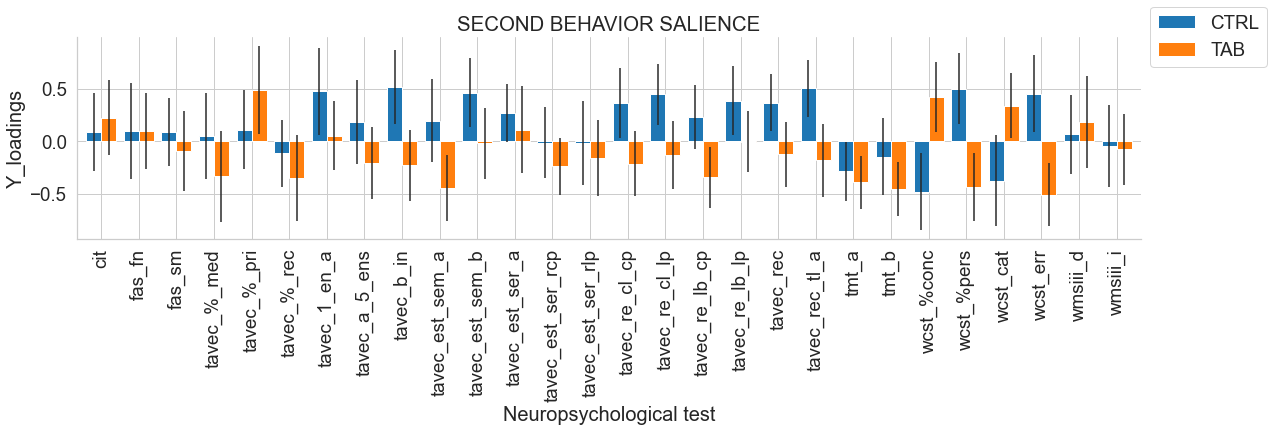

In [37]:
g = sns.FacetGrid(y_loadings_pls, aspect=3, height=6)
g.map_dataframe(errplot, 'condition', 'y_loadings', 'err', 'group',color=['C0', 'C1'], width=0.8)
plt.subplots_adjust(right=0.90)
plt.legend(['CTRL','TAB'], loc='center left', bbox_to_anchor=(1,1))
plt.title('SECOND BEHAVIOR SALIENCE')
plt.xlabel('Neuropsychological test', fontsize = 20)
plt.ylabel('Y_loadings', fontsize = 20)
plt.savefig('figures/pls_functional.png')
plt.show()


## Gráficos de dispersión

In [38]:
score_pls = pd.DataFrame()
score_pls['subject'] = all_data_sorted['subject']
score_pls['group'] = all_data_sorted['group']
score_pls['psy_wcst_%conc'] = all_data_sorted['psy_wcst_%conc']
score_pls['psy_wcst_%pers'] = all_data_sorted['psy_wcst_%pers']
score_pls['psy_wcst_err'] = all_data_sorted['psy_wcst_err']
score_pls['x_score']=pls.x_scores[:,icx]
score_pls['y_score']=pls.y_scores[:,icx]
score_pls['is_paisa']= all_data_sorted['is_paisa']
score_pls['t-t']= all_data_sorted['t-t']
score_pls['hsp']= all_data_sorted['hsp']
score_pls['active_psychosis'] = all_data_sorted['active_psychosis']
score_pls['psychotic_symptoms '] = all_data_sorted['psychotic_symptoms ']
score_pls['spa_abuse'] = all_data_sorted['spa_abuse']
score_pls['alcohol_abuse'] = all_data_sorted['alcohol_abuse']
score_pls['years_alcohol_abuse'] = all_data_sorted['years_alcohol_abuse']
score_pls['years_spa'] = all_data_sorted['years_spa']
score_pls = score_pls.reset_index(drop=True)

In [39]:
score_pls.loc[score_pls.group.str.contains('TAB'), 'group'] = 'BD'
score_pls.loc[score_pls.group.str.contains('CTR'), 'group'] = 'HC'

In [40]:
score_pls

subject group  psy_wcst_%conc  psy_wcst_%pers  psy_wcst_err    x_score  \
0   CTRL002    HC       -1.526643        1.463749      1.800217  11.372739   
1   CTRL003    HC        0.705379       -0.777602     -0.749771   0.613891   
2   CTRL004    HC       -0.015370       -0.041602      0.095218   0.127400   
3   CTRL005    HC        0.995128       -0.549629     -1.120989   0.763634   
4   CTRL006    HC       -1.501558        0.484274      1.434749  -6.939608   
5   CTRL008    HC       -0.824635        1.133616      1.093327   3.433356   
6   CTRL009    HC        0.757882       -0.701153     -0.900100  -4.228533   
7   CTRL010    HC        0.927919       -0.671655     -0.952650  -3.973036   
8   CTRL011    HC        0.129875       -0.251799     -0.357238   0.327240   
9   CTRL012    HC        0.344585       -0.627696     -0.403910  -2.379053   
10  CTRL013    HC        0.851282       -0.720431     -0.841080  -0.860245   
11  CTRL015    HC       -0.238288       -0.250836      0.561960   3.946752   
12  CTRL016    HC        0.415171       -0.307118     -0.508857  -0.267093   
13  CTRL018    HC        0.532333       -0.827310     -0.418765  -4.823530   
14  CTRL019    HC        1.062980       -0.781764     -0.956686  -4.721543   
15  CTRL020    HC       -1.278285        1.639105      1.713890  -3.565714   
16  CTRL021    HC       -1.982069        1.166736      1.866276   6.761979   
17  CTRL022    HC        0.988984       -0.720079     -1.023699  -8.290751   
18  CTRL024    HC        0.247598       -0.270125     -0.059601  -2.991430   
19  CTRL025    HC       -0.011324       -0.166414     -0.023126   6.292749   
20  CTRL026    HC       -1.389309        0.889500      1.470723   3.006065   
21  CTRL028    HC        0.378893       -0.205333     -0.557729   6.554016   
22  CTRL029    HC        1.062521       -0.653268     -1.138550  -2.070088   
23  CTRL030    HC       -0.145450        0.536217      0.270021   1.010101   
24  CTRL032    HC       -0.496727        0.304258      0.245863   5.786998   
25  CTRL033    HC        0.239770       -0.290572     -0.286851  -8.649849   
26  CTRL034    HC        0.840165       -0.642903     -0.836453  -6.201144   
27  TABP005    BD       -0.562810        0.344485      0.485527  -4.129012   
28  TABP017    BD       -0.928643        0.973981      1.305182  -3.272616   
29  TABP018    BD        0.613442       -0.939789     -0.849520   5.182613   
30  TABP021    BD        0.320210       -0.635849     -0.133196  -3.432539   
31  TABP024    BD        1.139097       -1.274763     -0.928572   2.290672   
32  TABP025    BD        0.903635       -1.032654     -0.862058  10.079095   
33  TABP035    BD        0.867039       -0.742258     -0.908851  -1.259597   
34  TABP037    BD       -0.145560        0.783143      0.386432  -7.488974   
35  TABP040    BD        0.759418       -0.325471     -0.289816   3.275385   
36  TABP044    BD        0.313626       -0.505139     -0.349598  -1.428947   
37  TABP054    BD        0.136593       -0.088087     -0.555420  -0.067128   
38  TABP055    BD       -1.095156        1.079247      1.216111   0.646341   
39  TABP060    BD        1.239873       -1.064306     -1.326019   8.965322   
40  TABP061    BD        0.908626       -0.955766     -0.862283   1.293080   
41  TABP065    BD        0.184863       -0.243633     -0.467670   0.396424   
42  TABP067    BD        1.436290       -1.283301     -1.359202  -4.791941   
43  TABP068    BD       -0.077852        0.056440      0.138734  -2.357045   
44  TABP069    BD       -0.828558        0.805340      1.287259  -3.485081   
45  TABP070    BD       -0.497083        0.698473      0.953321  -2.398981   
46  TABP082    BD       -1.151067        1.103946      0.836874  -4.230080   
47  TABP086    BD       -2.288035        2.455193      0.147632  -0.527682   
48  TABP092    BD       -1.374666        1.173473      1.588903  -3.775150   
49  TABP093    BD        0.117751        0.312351      0.377243  -0.186237   
50  TABP095    BD       -1

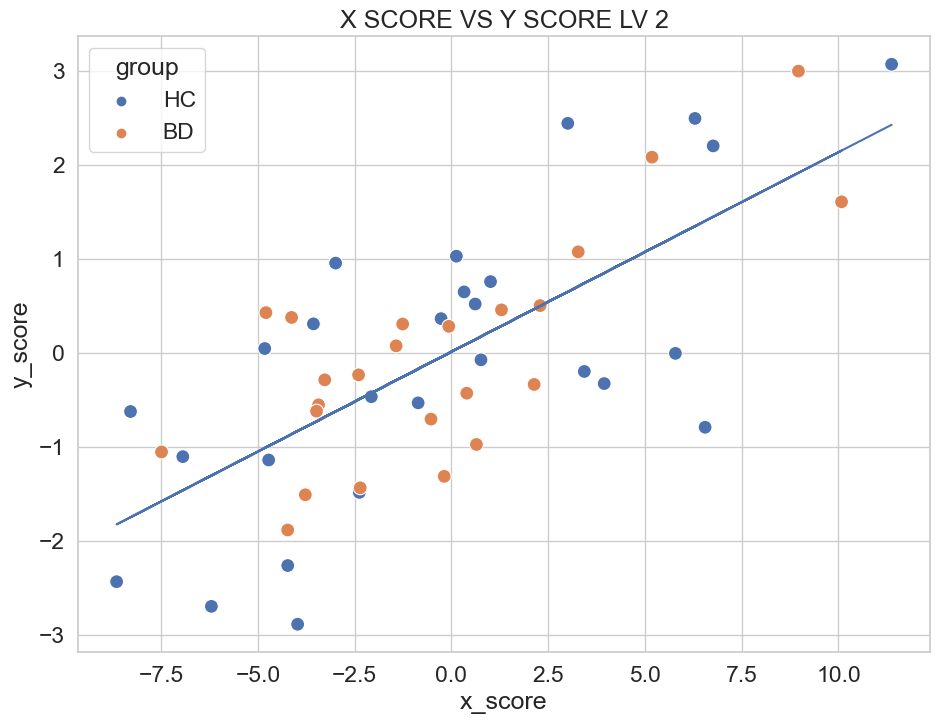

In [41]:
# Gráfico x vs y scores con regresión 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.scatterplot(x="x_score", y="y_score",hue= 'group', data=score_pls, s=100)
x=score_pls["x_score"]
y=score_pls["y_score"]
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b) 
plt.title("X SCORE VS Y SCORE LV 2")
plt.show()

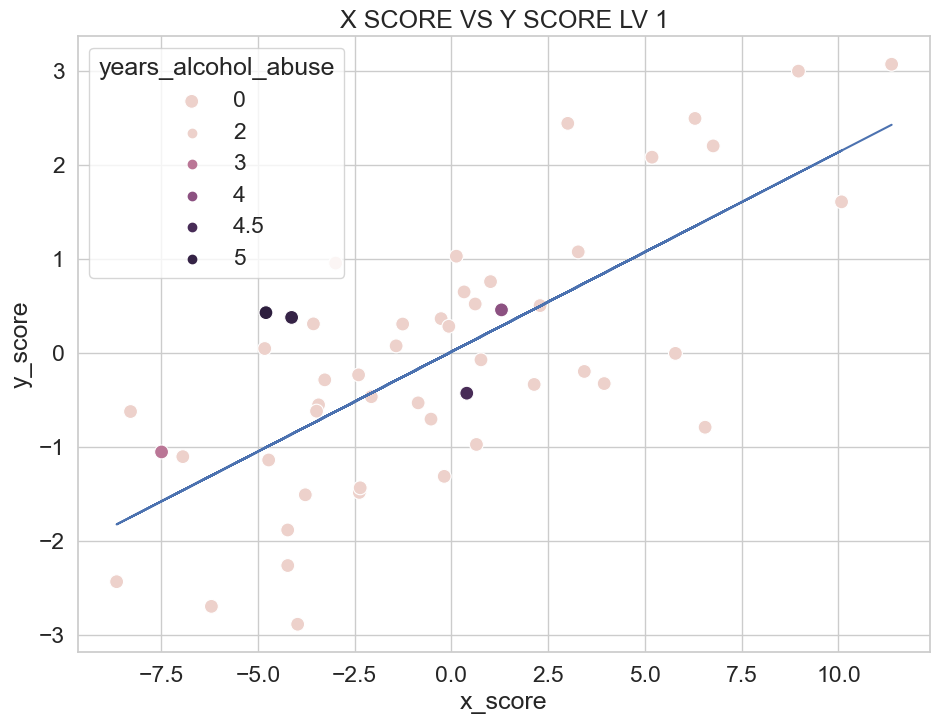

In [42]:
# Gráfico x vs y scores con regresión variables clínicas
hue_var = 'years_alcohol_abuse'
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)

idx = np.where(score_pls[hue_var]>0)

score_pls.loc[idx[0],hue_var] = np.log2(score_pls[hue_var][idx[0]])

sns.scatterplot(x="x_score", y="y_score",hue= hue_var, data=score_pls, s=100)
x=score_pls["x_score"]
y=score_pls["y_score"]
m, b = np. polyfit(x, y, 1)
plt. plot(x, m*x + b) 
plt.title("X SCORE VS Y SCORE LV 1")
plt.legend(['0','2','3','4','4.5','5'], title= hue_var)
plt.show()

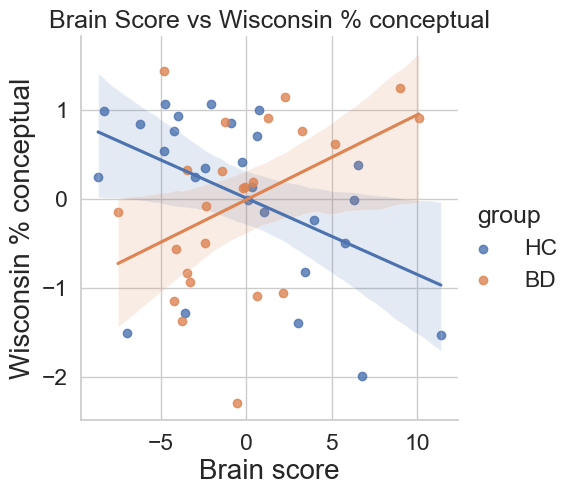

In [43]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_cp (recuerdo claves a corto plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="x_score", y='psy_wcst_%conc',
                  hue="group", data=score_pls)

plt.title("Brain Score vs Wisconsin % conceptual")
plt.ylabel('Wisconsin % conceptual', fontsize = 20)  
plt.xlabel('Brain score', fontsize = 20)
plt.savefig('figures/x_score_vs_wcst_%conc.png')
plt.show()

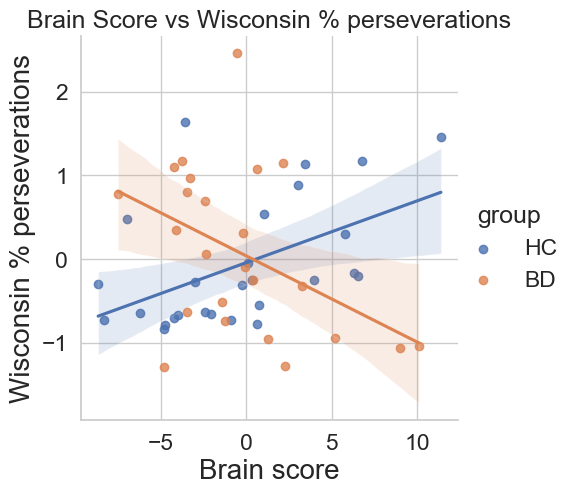

In [44]:
# Gráfico variable latente 1 vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="x_score", y='psy_wcst_%pers', hue="group", data=score_pls)

plt.title("Brain Score vs Wisconsin % perseverations")
plt.ylabel('Wisconsin % perseverations', fontsize = 20)  
plt.xlabel('Brain score', fontsize = 20)
plt.savefig('figures/x_score_vs_wcst_%pers.png')
plt.show()

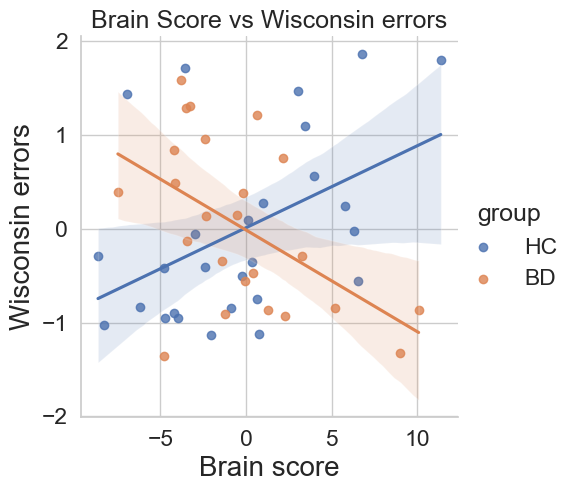

In [45]:
# Gráfico variable latente  vs psy_tavec_re_cl_lp (recuerdo claves a largo plazo)
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="x_score", y='psy_wcst_err', hue="group", data=score_pls)

plt.title("Brain Score vs Wisconsin errors")
plt.ylabel('Wisconsin errors', fontsize = 20)  
plt.xlabel('Brain score', fontsize = 20)
plt.savefig('figures/x_score_vs_wcst_err.png')
plt.show()

## Gráficos x-weights

In [46]:
import nibabel as nib

yeo_palett = {'Vis': (0.47058823529411764, 0.07058823529411765, 0.5254901960784314),
 'SomMot': (0.27450980392156865, 0.5098039215686274, 0.7058823529411765),
 'DorsAttn': (0.0, 0.4627450980392157, 0.054901960784313725),
 'SalVentAttn': (0.7686274509803922, 0.22745098039215686, 0.9803921568627451),
 'Limbic': (0.8627450980392157, 0.9725490196078431, 0.6431372549019608),
 'Cont': (0.9019607843137255, 0.5803921568627451, 0.13333333333333333),
 'Default': (0.803921568627451, 0.24313725490196078, 0.3058823529411765),
 'other': (0.7, 0.7, 0.7),
 'TempPar': (0, 0, 0.99)}

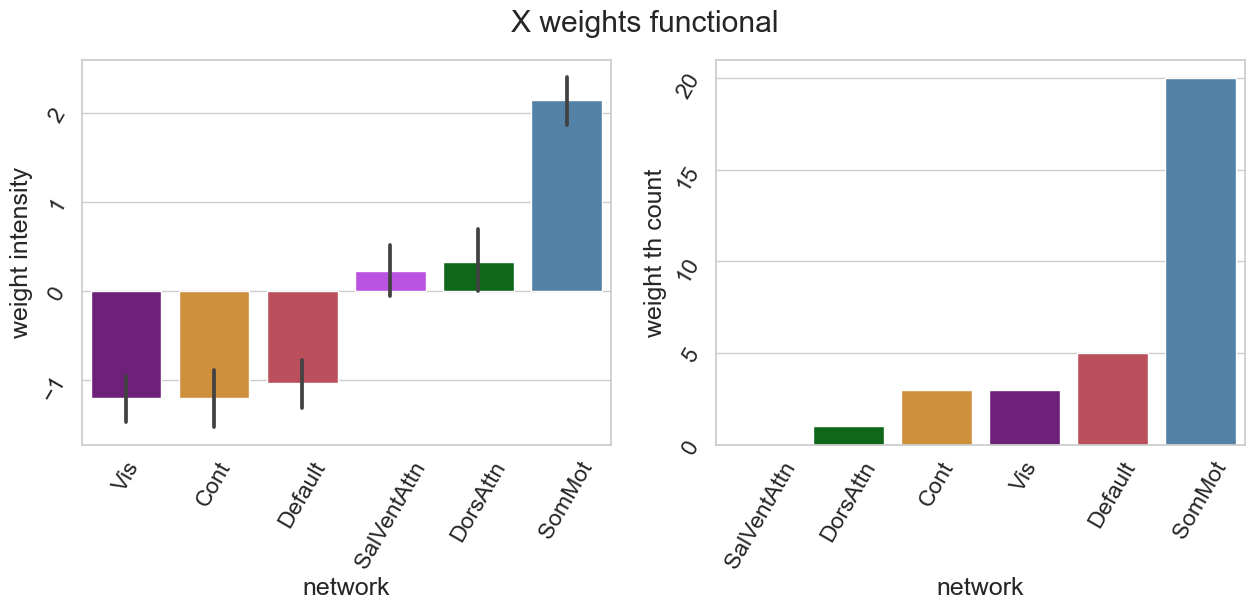

In [47]:
# Gráfico de barras estructuras corticales
sch_x_sch_weights = pls.bootres.x_weights_normed[:,icx]
df_x_weights_sch = pd.DataFrame(sch_x_sch_weights, columns=["weight"])
df_x_weights_sch.index = all_data_sorted.columns[:385]
df_x_weights_sch["network"] = df_x_weights_sch.index.str.split('_').str.get(2)

df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Vis'), 'network'] = 'Vis'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('SomMot'), 'network'] = 'SomMot'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('DorsAttn'), 'network'] = 'DorsAttn'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('SalVentAttn'), 'network'] = 'SalVentAttn'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Limbic'), 'network'] = 'Limbic'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Cont'), 'network'] = 'Cont'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('Default'), 'network'] = 'Default'
df_x_weights_sch.loc[df_x_weights_sch.network.str.contains('TempPar'), 'network'] = 'Default'

th = 3
df_x_weights_sch["weight_th"] =  (abs(df_x_weights_sch["weight"])>= th)*1

fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))
fig.suptitle('X weights functional')

order_g = df_x_weights_sch.groupby(["network"]).mean().sort_values(by='weight').index
g = sns.barplot(x="network", y="weight", ax=axes[0], order= order_g,palette=yeo_palett,
            data=df_x_weights_sch)
g.set(ylabel='weight intensity')
g.tick_params(labelrotation=60)
order_h = df_x_weights_sch.groupby(["network"]).sum().sort_values(by='weight_th').index
h = sns.barplot(x="network", y="weight_th", ci=None, ax=axes[1], estimator=sum,order= order_h,palette=yeo_palett,
            data=df_x_weights_sch)
h.set(ylabel='weight th count')
h.tick_params(labelrotation=60)
# Incluir ROIs en una tabla

In [48]:
df_x_weights_sch = df_x_weights_sch.reset_index(drop=False)
df_x_weights_sch.rename(columns = {'index':'roi'}, inplace = True)

#df_x_weights_sch
networks7_order = pd.read_csv('data/Schaefer2018_400Parcels_Thalamus_Striatum_7Networks_order.txt',
                              header=None, delimiter='\t', index_col=0)
networks7_order.rename(columns = {1:'roi'}, inplace = True)
networks7_order = networks7_order['roi']

# Unión nombres de los ROI
df_x_weights_sch_all = pd.merge(networks7_order, df_x_weights_sch, how='left', on=['roi'])
df_x_weights_sch_all['weight'] = df_x_weights_sch_all['weight'].fillna(0)
df_x_weights_sch_all["network"] = df_x_weights_sch_all.roi.str.split('_').str.get(2)
#df_x_weights_sch_all

In [ ]:
df_x_weights_sch.to_csv('x_weights_all_rois.csv')

/opt/miniconda3/lib/python3.9/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning: you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True
  warnings.warn('you have specified symmetric_cmap=False '
/opt/miniconda3/lib/python3.9/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



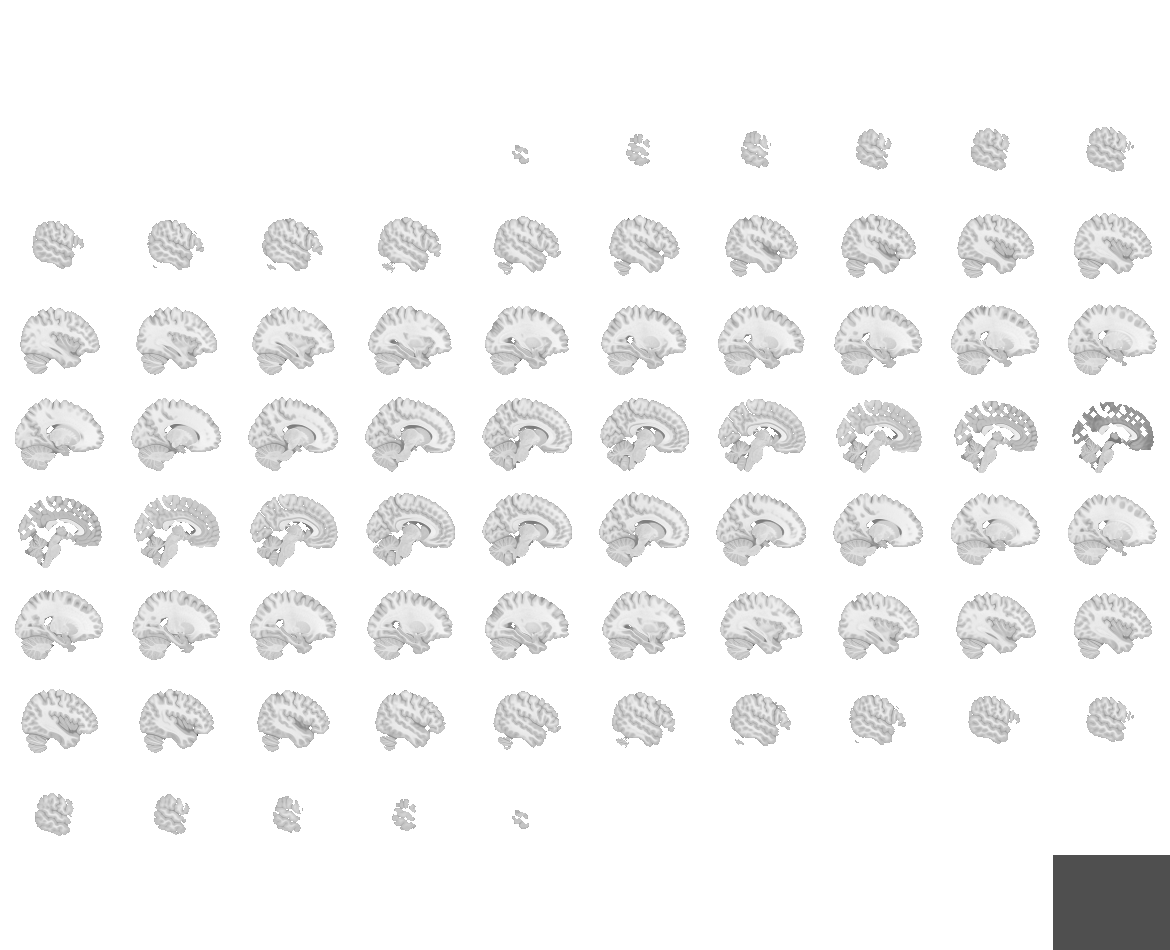
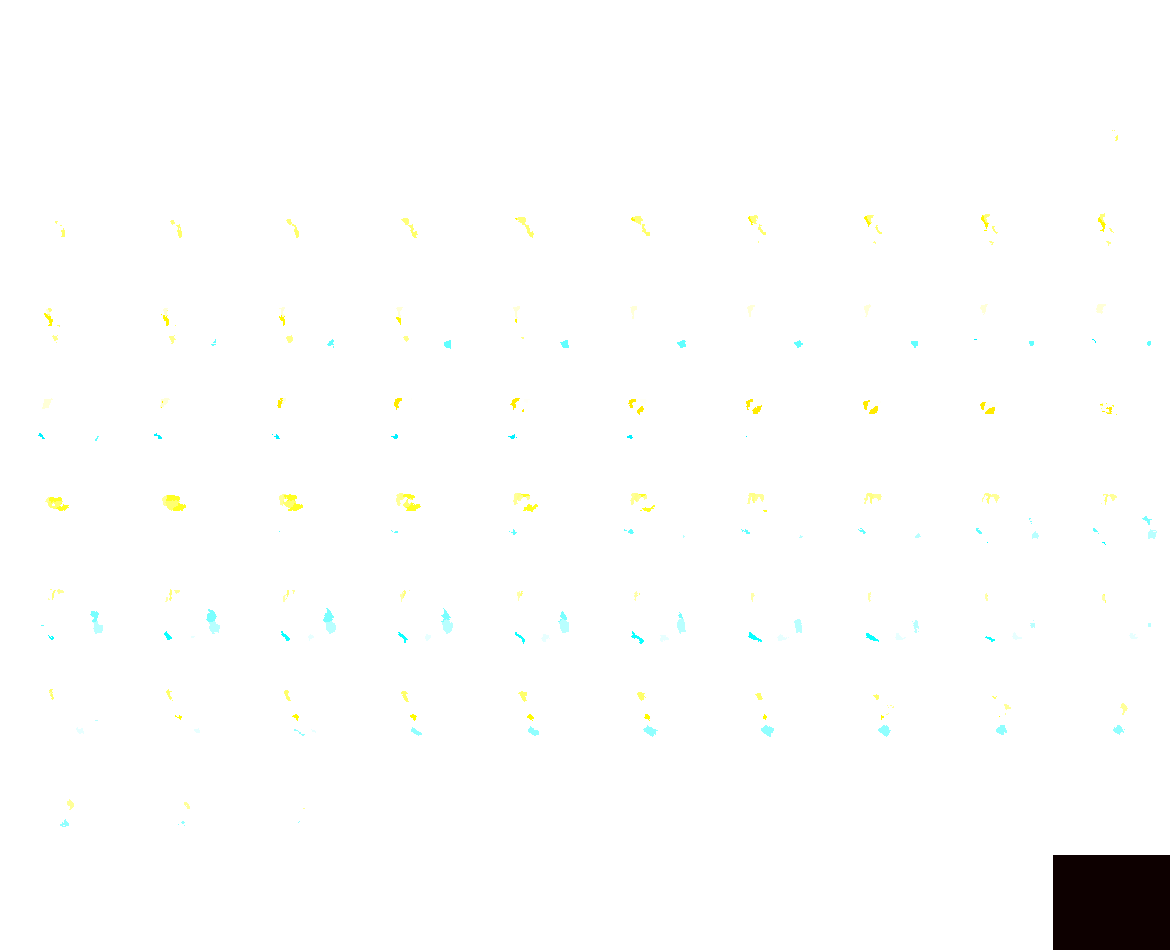

In [50]:
schaefer_image = 'data/Schaefer2018_400Parcels_Thalamus_Striatum_7Networks_order_FSLMNI152_2mm.nii' 
sch_masker=input_data.NiftiLabelsMasker(schaefer_image)
sch_values=sch_masker.fit()
th=3
values_brain_weight_func = sch_masker.inverse_transform(df_x_weights_sch_all.weight.values[np.newaxis,:])
plotting.view_img(values_brain_weight_func, threshold=th, title='X weights', black_bg=False,
                  symmetric_cmap=False, opacity=1)

In [ ]:
from nilearn import surface
from nilearn import plotting
from nilearn import datasets


fsaverage = datasets.fetch_surf_fsaverage()

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), subplot_kw={'projection': '3d'})

texture1 = surface.vol_to_surf(values_brain_weight_func, fsaverage.pial_left)
texture2 = surface.vol_to_surf(values_brain_weight_func, fsaverage.pial_right)

plotting.plot_surf_stat_map(fsaverage.infl_left, texture1, hemi='left', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_left, cmap='magma',
                            axes=ax[0,0],figure = fig, view='medial')

plotting.plot_surf_stat_map(fsaverage.infl_left, texture1, hemi='left', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_left, cmap='magma',
                            axes=ax[0,1],figure = fig, view='lateral')

plotting.plot_surf_stat_map(fsaverage.infl_right, texture2, hemi='right', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_right, cmap='magma',
                            axes=ax[1,0],figure = fig, view='medial')

plotting.plot_surf_stat_map(fsaverage.infl_right, texture2, hemi='right', colorbar=True,
                            threshold=3., bg_map=fsaverage.sulc_right, cmap='magma',
                            axes=ax[1,1],figure = fig, view='lateral')
plotting.show()

In [ ]:
# Mapeo personalizado de de Shaefer 7Net con info de colores
#coord_schaef= pd.read_csv('data/Schaefer2018_400Parc_Map_7NetColor.csv')
#coord_schaef.set_index('roi_name', inplace= True)
#labels_sign = df_x_weights_sch.loc[df_x_weights_sch['weight_th'] == 1].index

#adj_mat = np.zeros((len(labels_sign), len(labels_sign)))

#coord_schaef= coord_schaef.loc[labels_sign]

#node_cmap= np.array(coord_schaef.iloc[:,4:])

#plotting.plot_connectome(adj_mat, coord_schaef.iloc[:,1:4], node_color= node_cmap,
                         #node_size=100)

In [49]:
df_x_weights_sch.loc[df_x_weights_sch['weight_th'] == 1]

roi    weight   network  weight_th
19               7Networks_LH_Vis_20 -3.074418       Vis          1
33             7Networks_LH_SomMot_3  3.714022    SomMot          1
44            7Networks_LH_SomMot_14  3.606741    SomMot          1
47            7Networks_LH_SomMot_17  3.638072    SomMot          1
51            7Networks_LH_SomMot_21  3.656302    SomMot          1
54            7Networks_LH_SomMot_24  3.042641    SomMot          1
59            7Networks_LH_SomMot_29  4.058056    SomMot          1
62            7Networks_LH_SomMot_32  3.027512    SomMot          1
63            7Networks_LH_SomMot_33  4.200217    SomMot          1
66            7Networks_LH_SomMot_36  4.076422    SomMot          1
78     7Networks_LH_DorsAttn_Post_11  3.093971  DorsAttn          1
157       7Networks_LH_Default_PFC_6 -3.557461   Default          1
188               7Networks_RH_Vis_2 -3.187469       Vis          1
203              7Networks_RH_Vis_17 -3.566689       Vis          1
227           7Networks_RH_SomMot_11  3.145730    SomMot          1
231           7Networks_RH_SomMot_15  3.798930    SomMot          1
239           7Networks_RH_SomMot_23  3.606355    SomMot          1
240           7Networks_RH_SomMot_24  3.290109    SomMot          1
243           7Networks_RH_SomMot_27  3.849466    SomMot          1
246           7Networks_RH_SomMot_30  3.641143    SomMot          1
248           7Networks_RH_SomMot_32  3.795376    SomMot          1
250           7Networks_RH_SomMot_34  3.666418    SomMot          1
254           7Networks_RH_SomMot_38  3.281725    SomMot          1
255           7Networks_RH_SomMot_39  3.787615    SomMot          1
256           7Networks_RH_SomMot_40  3.731407    SomMot          1
316         7Networks_RH_Cont_PFCl_3 -3.943826      Cont          1
321         7Networks_RH_Cont_PFCl_8 -3.659689      Cont          1
327        7Networks_RH_Cont_PFCl_14 -4.242641      Cont          1
343      7Networks_RH_Default_Temp_4 -3.756089   Default          1
348      7Networks_RH_Default_PFCv_1 -4.130377   Default          1
360  7Networks_RH_Default_PFCdPFCm_9 -3.802773   Default          1
365   7Networks_RH_Default_pCunPCC_1 -3.385945   Default          1

In [ ]:
# Gráficos superficie
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.plotting import plot_surf

In [ ]:
col_fsa = parcel_to_surface(df_x_weights_sch_all.weight.values[:400],'schaefer_400_fsa5')
plot_cortical(array_name=col_fsa, surface_name="fsa5", size=(800, 400),
              cmap='magma', color_bar=True, color_range=(-3,3), embed_nb=True)

## PLS invirtiendo X: behavior, Y: fuerza de conexión

In [ ]:
# Matriz X: datos de volúmenes
Y = all_data_sorted.iloc[:,:385].values
X = all_data_sorted[y_list].values

In [ ]:
pls2 = pyls.behavioral_pls(X, Y, groups=list_len, seed=42, n_proc='max')

In [ ]:
pvals2 = pls2.permres['pvals']
x_weights = pls2.bootres.x_weights_normed # 28 
y_weights = pls2.y_weights # 900 (450 características por grupo)
pvals2

In [ ]:
sig_ind = np.where(pvals2 < 0.05)[0]
sig_ind

In [ ]:
pls.varexp[sig_ind]

In [ ]:
conditions2 = all_data_sorted.iloc[:,:385].columns.to_list()
#conditions2

In [ ]:
conditions = []
for j in conditions2:
    conditions = conditions + [j + '-' + i for i in groups]
#conditions

In [ ]:
# Gráfico que condiciones que no pasan por cero
icx = 0
err = (pls2["bootres"]["y_loadings_ci"][:, icx, 1] - pls2["bootres"]["y_loadings_ci"][:, icx, 0]) / 2   
ind_sig = np.where(abs(err) < abs(pls2["y_loadings"][:, icx]))[0]

color_list = ['C0','C1']

In [ ]:
new_ind = list()
for i in range(len(ind_sig)):
    if ind_sig[i] % 2 == 0: # Si el índice es par
        if i==len(ind_sig)-1:
            new_ind.insert(i+1, ind_sig[i] + 1)
            
        elif ind_sig[i] + 1 == ind_sig[i+1]: # Si los dos índices son consecutivos 
            flag = 'ok'
        else:
            new_ind.insert(i+1, ind_sig[i] + 1) # Insertar consecutivo 
            flag = 'ok'
    else: # Si el índice es impar
        if i==0:
            new_ind.insert(0, ind_sig[i] - 1) # Insertar en la primera posición
            
        elif ind_sig[i] - 1 == ind_sig[i-1]:
            flag = 'ok'
        else:
            new_ind.insert(i-1, ind_sig[i] - 1)
            #print('no')
            
new_sig = list(ind_sig) + new_ind
new_sig.sort()

In [ ]:
# Gráfico y loadings 
fig, axs = plt.subplots(1, 1, figsize=(6,40))
err_sig = (pls2["bootres"]["y_loadings_ci"][new_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][new_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][new_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i[10:-5] for i in conditions]
axs.set_yticks(np.arange(len(new_sig)))
labels = np.array(conditions_new)[new_sig]
labels[1::2] = ' '
axs.set_yticklabels(labels, fontsize = 20)
axs.legend(axx,['ctrl','tab'], fontsize = 20)

In [ ]:
# Grafico variables que separan los grupos
structure = '7Networks_LH_Default_PFC_9'
cor_sig  = [conditions.index(structure + '-CTRL'),
            conditions.index(structure + '-TAB')]
newfig, axs = plt.subplots(1, 1, figsize=(5,3))
err_sig = (pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 1] - pls2["bootres"]["y_loadings_ci"][cor_sig, icx, 0]) / 2   
axx= axs.barh(np.arange(len(err_sig)), pls2["y_loadings"][cor_sig, icx], xerr=err_sig, color=color_list)
conditions_new = [i[10:-5] for i in conditions]
labels = np.array(conditions_new)[cor_sig]
axs.set_yticks(np.arange(len(cor_sig)))
labels[1::2] = ' '
axs.set_yticklabels(labels, fontsize = 20)
axs.legend(axx,['ctrl','tab'], fontsize = 20)

In [ ]:
score_pls2 = pd.DataFrame()
score_pls2['subject'] = all_data_sorted['subject']
score_pls2['group'] = all_data_sorted['group']
score_pls2[structure] = all_data_sorted[structure]
score_pls2['x_score']=pls2.x_scores[:,0]
score_pls2['y_score']=pls2.y_scores[:,0]

In [ ]:
# Gráfico x vs y scores con regresión 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)
sns.lmplot(x="x_score", y="y_score", hue="group",data=score_pls2)

plt.title("X SCORE VS Y SCORE LV 1")
plt.show()

In [ ]:
# Gráfico variable latente 1 vs strength 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="x_score", y=structure,
                  hue="group", data=score_pls2)

plt.title("X SCORE VS " + structure[10:])
plt.ylabel(structure[10:])
plt.show()

In [ ]:
# Gráfico variable latente 1 vs strength 
sns.set(rc={'figure.figsize':(11,8)})
sns.set_theme(style='whitegrid', font_scale=1.5)  
        
g=sns.lmplot(x="y_score", y=structure,
                  hue="group", data=score_pls2)

plt.title("Y SCORE VS " + structure[10:])
plt.ylabel(structure[10:])
plt.show()